###  Libraries

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Datasets.Datasets_Functions import *
from Rings import Rings
from Common_Modules.Evaluation import Evaluator
from Common_Modules.Graph import Graph
from Common_Modules.Visualization import Visualization
from Common_Modules.General_Functions import General_Functions


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\traitlets\config\application.py", line 1075, in launch

### Global Variables

In [2]:
seed = 42
evaluator = Evaluator()
graph_is_enabled = True
kMeans_is_enabled = False
kernelKMeans_is_enabled = False
kernelKMeansPP_is_enabled = False
globalKernelKMeans_is_enabled = False
globalKernelKMeansPP_is_enabled = False
n_candidates = n_init = 100
kernel = 'rbf'
gamma = 1.0

### Visualization

In [3]:
visualization = Visualization()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

### Load Dataset

### 2Rings

In [4]:
if(False):
    # centers_coordinates = [(-1, 2), (2, 2), (2, 5), (2, -1), (5, 2), (6, 6), (-2, 6), (2, 8), (6, -2), (2, -4), (-2, -2)]
    centers_coordinates = [(-1, 2), (2, 2)]
    rings = Rings(colors)
    X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=100, factor=0.2, noise=0.0)

    K = 2 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)

### 3Rings

In [5]:
if (False):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    class Rings:
        def __init__(self, colors, seed=42):
            self.colors = colors
            self.seed = seed

        def plot(self, X, labels_):
            plt.scatter(X[:, 0], X[:, 1], c=labels_, cmap=ListedColormap(self.colors))
            plt.show()

        def move_rings(self, center_coordinates, X):
            X[:, 0] += center_coordinates[0]
            X[:, 1] += center_coordinates[1]
            return X

        def generate_circle(self, n_samples, radius, noise):
            angles = np.linspace(0, 2 * np.pi, n_samples, endpoint=False)
            X = np.c_[radius * np.cos(angles), radius * np.sin(angles)]
            X += noise * np.random.randn(n_samples, 2)
            return X

        def make_concentric_rings(self, centers_coordinates, n_samples=300, radii=[1, 2, 3], noise=0.05):
            pairs = []
            label = 0

            for center_coordinates in centers_coordinates:
                X_list, y_list = [], []
                for i, radius in enumerate(radii):
                    X = self.generate_circle(n_samples // len(radii), radius, noise)
                    y = np.full(X.shape[0], i)  # Assign unique label for each ring
                    X_list.append(X)
                    y_list.append(y)

                # Concatenate all rings
                X = np.concatenate(X_list)
                y = np.concatenate(y_list)

                X = self.move_rings(center_coordinates, X)

                pairs.append((X, y))
                label += len(radii)

            return self.concatenate_pairs(pairs)

        def concatenate_pairs(self, pairs):
            X = np.concatenate([X for X, _ in pairs])
            y = np.concatenate([y for _, y in pairs])
            self.plot(X, y)
            return X, y

    # Example usage:
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    rings = Rings(colors=colors)

    # Define the center for the single set of three concentric rings
    centers_coordinates = [(0, 0)]

    # Generate and plot the rings
    X, y = rings.make_concentric_rings(centers_coordinates=centers_coordinates, n_samples=150, radii=[1, 10, 25], noise=0)

    K = 3 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='sigmoid')
    print(X)

### 1 Ring with 2 Gaussians Inside

In [6]:
if(False):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    from sklearn.metrics.pairwise import pairwise_kernels
    import copy
    
    class Rings:
        def __init__(self, colors, seed=42):
            self.colors = colors
            self.seed = seed
            np.random.seed(self.seed)
    
        def plot(self, X, labels_):
            plt.scatter(X[:, 0], X[:, 1], c=labels_, cmap=ListedColormap(self.colors))
            plt.axis('off')
            plt.show()
    
        def generate_circle(self, n_samples, radius, noise):
            angles = np.linspace(0, 2 * np.pi, n_samples, endpoint=False)
            X = np.c_[radius * np.cos(angles), radius * np.sin(angles)]
            X += noise * np.random.randn(n_samples, 2)
            return X
    
        def generate_gaussians(self, n_samples, means, cov, labels):
            X = np.vstack([np.random.multivariate_normal(mean, cov, n_samples) for mean in means])
            y = np.hstack([[label]*n_samples for label in labels])
            return X, y
    
        def make_multiple_rings_with_gaussians(self, centers_coordinates, n_samples=100, radius=10, noise=0.05, gaussian_samples=50):
            X_list, y_list = [], []
            label_offset = 0
            
            for center_coordinates in centers_coordinates:
                # Generate ring
                X_ring = self.generate_circle(n_samples, radius, noise)
                y_ring = np.full(X_ring.shape[0], label_offset)  # Label for the ring
                X_ring = self.move_rings(center_coordinates, X_ring)
                X_list.append(X_ring)
                y_list.append(y_ring)
                
                # Generate 2 Gaussians inside the ring
                gaussians_X, gaussians_y = self.generate_gaussians(
                    gaussian_samples,
                    means=[(center_coordinates[0] - 1, center_coordinates[1]), 
                           (center_coordinates[0] + 1, center_coordinates[1])],  # Centered near the ring's center
                    cov=[[0.1, 0], [0, 0.1]],  # Covariance matrix
                    labels=[label_offset + 1, label_offset + 2]  # Unique labels for Gaussians
                )
    
                X_list.append(gaussians_X)
                y_list.append(gaussians_y)
    
                label_offset = label_offset + 3
            # Concatenate all parts
            X = np.concatenate(X_list)
            y = np.concatenate(y_list)
    
            self.plot(X, y)
            return X, y
    
        def move_rings(self, center_coordinates, X):
            X[:, 0] += center_coordinates[0]
            X[:, 1] += center_coordinates[1]
            return X
    
    # Usage example
    colors = ['purple', 'orange', 'blue', 'red', 'green', 'lime']
    
    rings = Rings(colors)
    centers_coordinates = [(5, 5), (-5, 5)]
    X, y = rings.make_multiple_rings_with_gaussians(centers_coordinates, n_samples=100, radius=3, noise=0.0, gaussian_samples=50)
    
    K = 3 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=0.5)

### 3Rings Paper

In [7]:
if (False):
    import scipy.io
    import numpy as np
    X_mat = scipy.io.loadmat('3circles_dataset.mat')
    X = np.array(X_mat['Dataset'])
    kernel_matrix_mat = scipy.io.loadmat('3circles_kernel_matrix.mat')
    kernel_matrix = np.array(kernel_matrix_mat['K'])
    y = np.loadtxt('array.txt').astype(int)
    K = 3
    rings.plot(X,y)
    print(y)

### Graphs

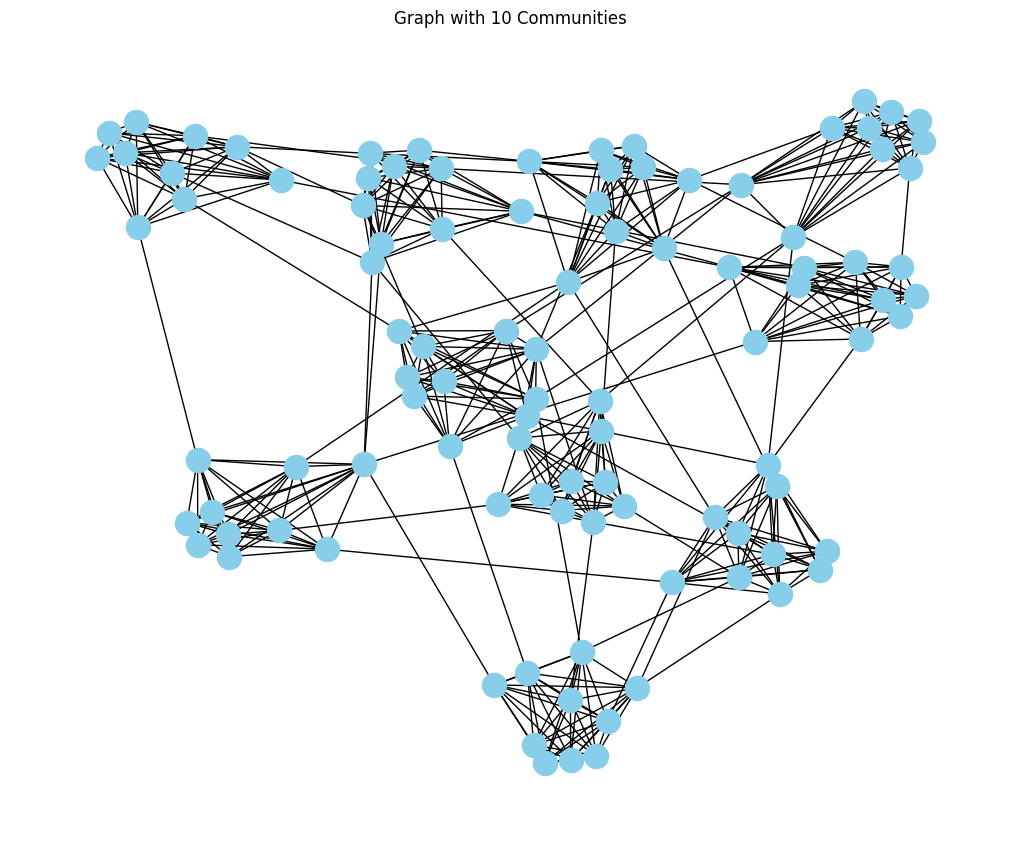

In [8]:
if(graph_is_enabled):
    # Number of nodes per community
    n_nodes_per_community = 10

    # Number of communities
    K = n_communities = 10
    
    # Probability of intra-community edge
    p_intra = 1  
    
    # Probability of inter-community edge
    p_inter = 0.01  

    graph = Graph(n_communities, n_nodes_per_community, p_intra, p_inter, colors)
    graph.create_adj_matrix()
    kernel_matrix = graph.adj_matrix = pairwise_kernels(graph.adj_matrix, graph.adj_matrix, metric='linear')
    graph.create_kernel_matrix_from_adj_matrix()

    from scipy.io import loadmat

    # Load the .mat file
    mat_file_path = 'add32.mat'  # Ensure this matches the name you saved it as
    data = loadmat(mat_file_path)

    # Access the first element of the structured array
    add32_data = data['Problem'][0]  # Access the first (and likely only) element

    # Extracting the fields from the structured array
    title = add32_data['title'][0][0]  # Get the title (1st field)
    A = add32_data['A'][0]              # The sparse matrix
    b = add32_data['b'][0]              # The vector associated with the matrix
    name = add32_data['name'][0][0]     # Name of the dataset
    author = add32_data['author'][0][0] # Author of the dataset
    date = add32_data['date'][0][0]     # Date of creation
    kind = add32_data['kind'][0][0]     # Kind of problem

    kernel_matrix = graph.adj_matrix = pairwise_kernels(A, A, metric='linear')

### kMeans

In [9]:
if(kMeans_is_enabled):
    kmeans = KMeans(n_clusters=K).fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
    evaluator.print_evaluation()
    visualization.plot_tsne(X, y, data_dir_path="Figures\\"+dataset_name)

### Kernel kMeans

In [10]:
if(kernelKMeans_is_enabled):
    kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
    evaluator.print_evaluation()
    visualization.plot_tsne(X, y, data_dir_path="Figures\\"+dataset_name)

### Kernel kMeans++

In [11]:
if(kernelKMeansPP_is_enabled):
    n_iters_ = {}
    execution_times_ = {}
    inertias_ = {}
    #init = "random"
    #init = "k-means++"
    init = "forgy"
    #General_Functions.append_to_csv(f"{data_dir_path}KernelKMeans_Dataset_{dataset_name}_Init_{init}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv", new_row)
    prev_K = K
    K = 2
    while (K != prev_K + 1):
        print(K)
        kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=n_init, init=init, verbose=0)
        kernelKMeans.fit()
        if graph_is_enabled:
            graph.plot_clusters(kernelKMeans.labels_)
        #else:
            #evaluation_results = General_Functions().append_to_file(y, kernelKMeans.labels_, kernelKMeans.inertia_, kernelKMeans.execution_times_, f"{data_dir_path}KernelKMeans_{init}_Results.txt")
            #visualization.plot_tsne(X, y, data_dir_path=data_dir_path + "KernelKMeans_" + init)
            #General_Functions.create_csv(kernelKMeans.inertia_, kernelKMeans.n_iters_, kernelKMeans.execution_times_, f"{data_dir_path}KernelKMeans_{init}_Results.csv")        
            # That's the function of grount truth error
            #ground_truth_error = kernelKMeans.calculate_ground_truth_error(y)
            #print(f"Ground Truth Error is: {ground_truth_error}")    
        n_iters_[K] = sum(kernelKMeans.n_iters_.values())
        execution_times_[K] = sum(kernelKMeans.execution_times_.values())
        inertias_[K] = kernelKMeans.inertia_
        new_row = { "K": K, "MSE": inertias_[K], "ITERATIONS": n_iters_[K], "EXECUTION TIME": execution_times_[K]}
        General_Functions.append_to_csv(f"{data_dir_path}KernelKMeans_Dataset_{dataset_name}_Init_{init}_Kernel_{kernel}_K_{prev_K}_Inits_{n_init}_Results.csv", new_row)
        K += 1
    K = prev_K   

### Global Kernel kMeans

In [12]:
if(globalKernelKMeans_is_enabled):
    globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv", verbose=1)
    globalKernelKMeans.fit()
    
    if graph_is_enabled:
        graph.plot_clusters(globalKernelKMeans.labels_[K])
    else:
        evaluation_results = General_Functions().append_to_file(y, globalKernelKMeans.labels_[K], globalKernelKMeans.inertia_[K], globalKernelKMeans.execution_times_, f"{data_dir_path}GlobalKernelKMeans_Results.txt")
        #visualization.plot_tsne(X, y, data_dir_path=data_dir_path + "\\GlobalKernelKMeans")
        #General_Functions.create_csv(globalKernelKMeans.inertia_, globalKernelKMeans.n_iters_, globalKernelKMeans.execution_times_, f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv")
# 0.265

### Global Kernel kMeans++

In [13]:
if(globalKernelKMeansPP_is_enabled):
    sampling = 'batch'
    sampling = 'sequential'
    globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=n_candidates, sampling=sampling, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Sampling_{sampling}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv", verbose=1)
    globalKernelKMeansPP.fit()
    if graph_is_enabled:  
        graph.plot_clusters(globalKernelKMeansPP.labels_[K])
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
        evaluation_results = General_Functions().append_to_file(y, globalKernelKMeansPP.labels_[K], globalKernelKMeansPP.inertia_[K], globalKernelKMeansPP.execution_times_,  f"{data_dir_path}GlobalKernelKMeans_{sampling}_Results.txt")
        #General_Functions.create_csv(globalKernelKMeansPP.inertia_, globalKernelKMeansPP.n_iters_, globalKernelKMeansPP.execution_times_, f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Sampling_{sampling}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv")
        #visualization.plot_tsne(X, y, data_dir_path= f"{data_dir_path}GlobalKernelKMeans_{sampling}_")

In [14]:
from scipy.io import loadmat

# Load the .mat file
mat_file_path = 'add32.mat'  # Ensure this matches the name you saved it as
data = loadmat(mat_file_path)

# Access the keys in the loaded data
keys = data.keys()  # Correctly get the keys from the dictionary

# Display the available keys
print("Keys in the .mat file:", keys)
data['Problem']

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'Problem'])


array([[(array(['32-bit adder, from Steve Hamm (Motorola) hamm@austoto.sps.mot.com'],
              dtype='<U65'), <Compressed Sparse Column sparse matrix of dtype 'float64'
        	with 19848 stored elements and shape (4960, 4960)>, <Compressed Sparse Column sparse matrix of dtype 'float64'
        	with 4036 stored elements and shape (4960, 4960)>, array([[ 1.86264861e-18],
               [ 1.88469719e-17],
               [ 0.00000000e+00],
               ...,
               [-1.33873623e-19],
               [-5.97176764e-18],
               [-9.72390877e-21]]), array(['Hamm/add32'], dtype='<U10'), array([[540]], dtype=uint16), array(['1991'], dtype='<U4'), array(['S. Hamm'], dtype='<U7'), array(['T. Davis'], dtype='<U8'), array(['circuit simulation problem'], dtype='<U26'))]],
      dtype=[('title', 'O'), ('A', 'O'), ('Zeros', 'O'), ('b', 'O'), ('name', 'O'), ('id', 'O'), ('date', 'O'), ('author', 'O'), ('ed', 'O'), ('kind', 'O')])